In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
from keras.models import Model, Sequential
from tqdm.auto import tqdm
from IPython.display import clear_output
from pathlib import Path

from PIL import Image, ImageEnhance

from metrics import gmsd, psnr, ssim
from models.spectral_encoder import recon_model, ssim_loss
from loader.dataloader import DataLoader
from reg.reg_a import RegA
from reg.reg_b import RegB

DATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/raw"
METADATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/data.h5"

## Load Data

In [2]:
# Load data
run_loader = DataLoader(DATA_DIR, METADATA_DIR)

## Randomly select test images

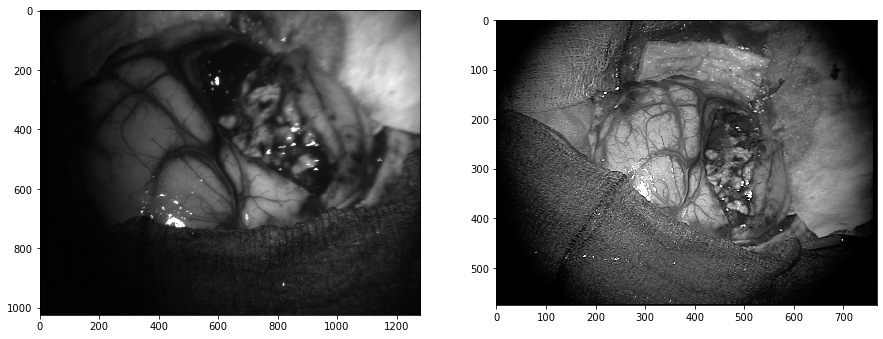

[(Run(Run06), 0)]

In [4]:
runs = []
for s in run_loader.samples:
    runs += s.runs
# # random_run = random.sample(runs, 40)
# random_run = random.sample(runs, 3) # short mode

sample_ = run_loader.samples[18]
random_run = [sample_.runs[2]]

filtered_runs = []
for run in random_run:
    clear_output(wait=True)

    run_coll = random.randint(0, run.collection_count - 1)

    SI = run.get_spectral_image(wavelength=600, collection_idx=run_coll)
    MI = run.get_label_image(channel="bw")

    try:
        run.get_spectral_images(collection_idx=run_coll, channel="b")
    except:
        continue

    # Plot SI and MI side by side
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(SI, cmap="gray")
    ax[1].imshow(MI, cmap="gray")
    plt.show()

    accept = input("Accept? (y/n): ")
    if accept == "y":
        filtered_runs.append((run, run_coll))

random_run = filtered_runs
random_run

# Util Function

In [37]:
KERNEL = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
FACTOR = 25

model = recon_model(input_shape=(None, None, 1))
model.load_weights("models/spectral_encoder.h5")
model.compile(optimizer="adam", loss=ssim_loss, metrics=["accuracy"])

encoder = Model(inputs=model.layers[0].input, outputs=model.layers[7].output)

decoder = Sequential()
for layer in model.layers[8:]:
    decoder.add(layer)


def get_rgb_inference(run, collection_idx=0, nomod=False):
    b_list = run.get_spectral_images(collection_idx=collection_idx, channel="b")
    g_list = run.get_spectral_images(collection_idx=collection_idx, channel="g")
    r_list = run.get_spectral_images(collection_idx=collection_idx, channel="r")

    w, h = b_list[0].shape

    b_feature_list = list()
    for img in b_list:
        img = np.array(img).reshape(-1, w, h, 1)
        img_feature = encoder.predict(img, verbose=0)
        b_feature_list.append(img_feature)

    g_feature_list = list()
    for img in g_list:
        img = np.array(img).reshape(-1, w, h, 1)
        img_feature = encoder.predict(img, verbose=0)
        g_feature_list.append(img_feature)

    r_feature_list = list()
    for img in r_list:
        img = np.array(img).reshape(-1, w, h, 1)
        img_feature = encoder.predict(img, verbose=0)
        r_feature_list.append(img_feature)

    fuse_b = sum(b_feature_list) / len(b_feature_list)
    img_target_b = decoder.predict(fuse_b, verbose=0)
    img_target_b = img_target_b.reshape(w, h)
    img_target_b = img_target_b.astype(np.uint8)
    if not nomod:
        img_target_b = cv2.filter2D(img_target_b, ddepth=-1, kernel=KERNEL)
        img_target_b = Image.fromarray(img_target_b)
        enhancer = ImageEnhance.Sharpness(img_target_b)
        img_target_b = enhancer.enhance(FACTOR)

    fuse_g = sum(g_feature_list) / len(g_feature_list)
    img_target_g = decoder.predict(fuse_g, verbose=0)
    img_target_g = img_target_g.reshape(w, h)
    img_target_g = img_target_g.astype(np.uint8)
    if not nomod:
        img_target_g = cv2.filter2D(img_target_g, ddepth=-1, kernel=KERNEL)
        img_target_g = Image.fromarray(img_target_g)
        enhancer = ImageEnhance.Sharpness(img_target_g)
        img_target_g = enhancer.enhance(FACTOR)

    fuse_r = sum(r_feature_list) / len(r_feature_list)
    img_target_r = decoder.predict(fuse_r, verbose=0)
    img_target_r = img_target_r.reshape(w, h)
    img_target_r = img_target_r.astype(np.uint8)
    if not nomod:
        img_target_r = cv2.filter2D(img_target_r, ddepth=-1, kernel=KERNEL)
        img_target_r = Image.fromarray(img_target_r)
        enhancer = ImageEnhance.Sharpness(img_target_r)
        img_target_r = enhancer.enhance(FACTOR)

    
    return img_target_b, img_target_g, img_target_r

In [27]:
# save_path = "/Users/farhanoktavian/imperial/thesis/sandbox/regist_eval/dataset/registered"
save_path = "/Users/farhanoktavian/imperial/thesis/sandbox/regist_eval/dataset/registered_short"
save_path = Path(save_path)

# if save_path.exists():
#     print("Directory already exists! Deleting save path...")
#     shutil.rmtree(save_path, ignore_errors=True)

def export_image(sample_id, run_id, label, img):
    img = img.astype(np.uint8)
    # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img_dir = Path(save_path / sample_id / run_id)
    img_dir.mkdir(parents=True, exist_ok=True)

    img_path = str(img_dir) + f"/{label}.png"
    cv2.imwrite(img_path, img)

# Iterate over runs

In [39]:
met_dict = {
    "gmsd": gmsd,
    "psnr": psnr,
    "ssim": ssim
}

df_init = {
    "sample_id": list(),
    "run_id": list(),
    "channel": list(),
    "a_gmsd": list(),
    "a_psnr": list(),
    "a_ssim": list(),
    "b_gmsd": list(),
    "b_psnr": list(),
    "b_ssim": list(),
    "a_gmsd_all": list(),
    "a_psnr_all": list(),
    "a_ssim_all": list(),
    "b_gmsd_all": list(),
    "b_psnr_all": list(),
    "b_ssim_all": list()
}

df = pd.DataFrame(df_init)


reg_a = RegA()
reg_b = RegB()

cnt = 0
for run, run_coll in tqdm(random_run, desc="Run"):
    cnt += 1

    try:
        SI = run.get_spectral_images(collection_idx=run_coll)
        SI_580 = run.get_spectral_image(wavelength=580, collection_idx=run_coll)
        SI_B, SI_G, SI_R = get_rgb_inference(run, collection_idx=run_coll)
        SI_B2, SI_G2, SI_R2 = get_rgb_inference(run, collection_idx=run_coll, nomod=True)
        MI = run.get_label_image(channel="bw")

        MI_G = None
        for ch in ["r", "g", "b"]:
            new_row = {
                "sample_id": run.sample_id,
                "run_id": run.run_id,
                "channel": ch,
            }

            SI_ch = None
            SI_ch2 = None
            if ch == "r":
                SI_ch = SI_R
                SI_ch2 = SI_R2
            elif ch == "g":
                SI_ch = SI_G
                SI_ch2 = SI_G2
            elif ch == "b":
                SI_ch = SI_B
                SI_ch2 = SI_B2
            else:
                raise ValueError("Invalid ch")
            SI_ch = np.array(SI_ch).astype(np.uint8)
            SI_ch2 = np.array(SI_ch2).astype(np.uint8)

            SI_chs = run.get_spectral_images(collection_idx=run_coll, channel=ch)

            MI_ch = run.get_label_image(channel=ch)

            # reg_a_M, reg_a_w, reg_a_h = reg_a.register(MI_ch, SI_ch)
            # MI_a = cv2.warpPerspective(MI_ch, reg_a_M, (reg_a_w, reg_a_h))
            # mask_a = MI_a.copy()
            # mask_a[MI_a >= 0] = 1

            reg_b_M, reg_b_w, reg_b_h = reg_b.register(MI_ch, SI_ch)
            MI_b = cv2.warpAffine(MI_ch, reg_b_M, (reg_b_w, reg_b_h))
            mask_b = MI_b.copy()
            mask_b[MI_b >= 0] = 1

            # for k, f in met_dict.items():
            #     # Per channel
            #     # metr_a = f(MI_a, SI_ch * mask_a)
            #     metr_b = f(MI_b, SI_ch * mask_b)

            #     # All channel
            #     metr_a_all = list()
            #     metr_b_all = list()
            #     for img in SI_chs:
            #         img = img.astype(np.uint8)
            #         metr_a_all.append(f(MI_a, img * mask_a))
            #         metr_b_all.append(f(MI_b, img * mask_b))
                
                # new_row[f"a_{k}"] = metr_a
                # new_row[f"b_{k}"] = metr_b
                # new_row[f"a_{k}_all"] = metr_a_all
                # new_row[f"b_{k}_all"] = metr_b_all
            
            # export_image(run.sample_id, run.run_id, f"{ch}_label_a", MI_a)
            # export_image(run.sample_id, run.run_id, f"{ch}_label_b", MI_b)
            # export_image(run.sample_id, run.run_id, f"{ch}_spectral", SI_ch)
            # export_image(run.sample_id, run.run_id, f"{ch}_spectral_a", SI_ch * mask_a)
            # export_image(run.sample_id, run.run_id, f"{ch}_spectral_b", SI_ch * mask_b)
            
            # export_image(run.sample_id, run.run_id, f"{ch}_label_a", MI_a)
            export_image(run.sample_id, run.run_id, f"{ch}_label", MI_b)
            export_image(run.sample_id, run.run_id, f"{ch}_spectral", SI_ch2)
            # export_image(run.sample_id, run.run_id, f"{ch}_spectral_a", SI_ch * mask_a)
            # export_image(run.sample_id, run.run_id, f"{ch}_spectral_b", SI_ch * mask_b)

            df = df.append(new_row, ignore_index=True)


    except Exception as e:
        print(f"Skipped {cnt} - {e}")
        pass


Run: 100%|██████████| 1/1 [00:58<00:00, 58.96s/it]


In [ ]:
mic = cv2.warpAffine(MI, reg_b_M, (reg_b_w, reg_b_h))
export_image(run.sample_id, run.run_id, f"gray-mic", mic)

In [49]:
df_r = df[df["channel"] == "r"]
df_g = df[df["channel"] == "g"]
df_b = df[df["channel"] == "b"]

# gmsd
print("-- GMSD --")
print(f"Red channel:")
print(f"  Reg A: {df_r['a_gmsd'].mean():.3f}")
print(f"  Reg B: {df_r['b_gmsd'].mean():.3f}")
print(f"Green channel:")
print(f"  Reg A: {df_g['a_gmsd'].mean():.3f}")
print(f"  Reg B: {df_g['b_gmsd'].mean():.3f}")
print(f"Blue channel:")
print(f"  Reg A: {df_b['a_gmsd'].mean():.3f}")
print(f"  Reg B: {df_b['b_gmsd'].mean():.3f}")
print(f"Overall:")
print(f"  Reg A: {df['a_gmsd'].mean():.3f}")
print(f"  Reg B: {df['b_gmsd'].mean():.3f}")
print()

# psnr
print("-- PSNR --")
print(f"Red channel:")
print(f"  Reg A: {df_r['a_psnr'].mean():.3f}")
print(f"  Reg B: {df_r['b_psnr'].mean():.3f}")
print(f"Green channel:")
print(f"  Reg A: {df_g['a_psnr'].mean():.3f}")
print(f"  Reg B: {df_g['b_psnr'].mean():.3f}")
print(f"Blue channel:")
print(f"  Reg A: {df_b['a_psnr'].mean():.3f}")
print(f"  Reg B: {df_b['b_psnr'].mean():.3f}")
print(f"Overall:")
print(f"  Reg A: {df['a_psnr'].mean():.3f}")
print(f"  Reg B: {df['b_psnr'].mean():.3f}")
print()

# ssim
print("-- SSIM --")
print(f"Red channel:")
print(f"  Reg A: {df_r['a_ssim'].mean():.3f}")
print(f"  Reg B: {df_r['b_ssim'].mean():.3f}")
print(f"Green channel:")
print(f"  Reg A: {df_g['a_ssim'].mean():.3f}")
print(f"  Reg B: {df_g['b_ssim'].mean():.3f}")
print(f"Blue channel:")
print(f"  Reg A: {df_b['a_ssim'].mean():.3f}")
print(f"  Reg B: {df_b['b_ssim'].mean():.3f}")
print(f"Overall:")
print(f"  Reg A: {df['a_ssim'].mean():.3f}")
print(f"  Reg B: {df['b_ssim'].mean():.3f}")
print()

-- GMSD --
Red channel:
  Reg A: 0.102
  Reg B: 0.096
Green channel:
  Reg A: 0.126
  Reg B: 0.124
Blue channel:
  Reg A: 0.132
  Reg B: 0.131
Overall:
  Reg A: 0.120
  Reg B: 0.117

-- PSNR --
Red channel:
  Reg A: 13.828
  Reg B: 14.534
Green channel:
  Reg A: 12.846
  Reg B: 12.750
Blue channel:
  Reg A: 12.063
  Reg B: 13.080
Overall:
  Reg A: 12.912
  Reg B: 13.455

-- SSIM --
Red channel:
  Reg A: 0.445
  Reg B: 0.475
Green channel:
  Reg A: 0.358
  Reg B: 0.359
Blue channel:
  Reg A: 0.233
  Reg B: 0.248
Overall:
  Reg A: 0.345
  Reg B: 0.360



In [50]:
# df.to_csv("dataset/registered.csv", index=False)
# df.to_hdf("dataset/registered.h5", key="df", mode="w")

df.to_csv("dataset/registered_short.csv", index=False)
df.to_hdf("dataset/registered_short.h5", key="df", mode="w")

Image similarity 0.22986096490383137


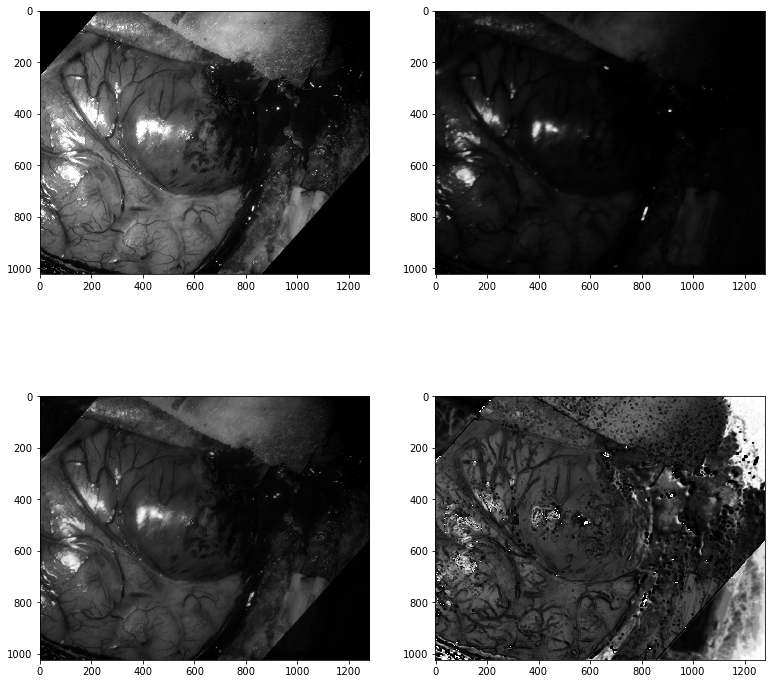

In [51]:
import ipywidgets as widgets
from skimage.metrics import structural_similarity

this_img = MI_b.copy()

(score, diff) = structural_similarity(this_img, SI_ch, full=True)
print("Image similarity", score)

diff = (diff * 255).astype("uint8")
merged = this_img * 0.5 + SI_ch * 0.5


fig, ax = plt.subplots(2, 2, figsize=(13, 13))
ax[0][0].imshow(this_img, cmap="gray", vmin=0, vmax=255)
ax[0][1].imshow(SI_ch, cmap="gray", vmin=0, vmax=255)
ax[1][0].imshow(merged, cmap="gray", vmin=0, vmax=255)
ax[1][1].imshow(diff, cmap="gray", vmin=0, vmax=255)
plt.show()

In [3]:
met_dict = {
    "gmsd": gmsd,
    "psnr": psnr,
    "ssim": ssim
}

paths = [
    Path("/Users/farhanoktavian/imperial/thesis/sandbox/regist_eval/images/curr/moving.png"),
    Path("/Users/farhanoktavian/imperial/thesis/sandbox/regist_eval/images/curr/test.png"),
    Path("/Users/farhanoktavian/imperial/thesis/sandbox/regist_eval/images/curr/fixed.png"),
]

imgs = []

for p in (paths):
    img_a = Image.open(p).convert("L")
    img_a = np.asarray(img_a)
    imgs.append(img_a)

for k, f in met_dict.items():
    print(f"Metric: {k}")
    res = f(imgs[0], imgs[2])
    print(f"  Before: {res:.3f}")
    res = f(imgs[1], imgs[2])
    print(f"  After: {res:.3f}")

Metric: gmsd
  Before: 0.116
  After: 0.122
Metric: psnr
  Before: 17.434
  After: 16.209
Metric: ssim
  Before: 0.564
  After: 0.549


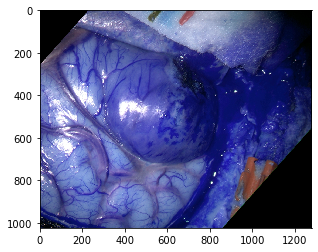

True

In [26]:
paths = [
    Path("/Users/farhanoktavian/imperial/thesis/sandbox/dataset/raw/HS017/Labelling data/Definitive segmentations/HS017 Capillary excluded/Run 01-03/Patient_3_2022-03-02_15-43-31_I.JPG"),
    Path("/Users/farhanoktavian/imperial/thesis/sandbox/regist_eval/dataset/registered_short/HS017/Run01/gray-mic.png"),
]

src_rgb = Image.open(paths[0]).convert("RGB")
src_rgb = np.asarray(src_rgb)
src_r, src_g, src_b = Image.open(paths[0]).split()
src_r = np.asarray(src_r)
src_g = np.asarray(src_g)
src_b = np.asarray(src_b)

tgt_bw = Image.open(paths[1]).convert("L")
tgt_bw = np.asarray(tgt_bw)

reg = RegB()
reg_M, reg_w, reg_h = reg.register(src_g, tgt_bw)

reg_b = cv2.warpAffine(src_b, reg_M, (reg_w, reg_h))
reg_g = cv2.warpAffine(src_g, reg_M, (reg_w, reg_h))
reg_r = cv2.warpAffine(src_r, reg_M, (reg_w, reg_h))

blank_rgb = np.zeros((imgs[0].shape[0], imgs[0].shape[1], 3), dtype=np.uint8)
blank_rgb[:, :, 0] = reg_b
blank_rgb[:, :, 1] = reg_g
blank_rgb[:, :, 2] = reg_r

fig, ax = plt.subplots(1, 1)
ax.imshow(blank_rgb)
plt.show()

savepath = "/Users/farhanoktavian/imperial/thesis/sandbox/regist_eval/dataset/demo/"

cv2.imwrite(str(savepath + "rgb.png"), blank_rgb)
cv2.imwrite(str(savepath + "r.png"), reg_r)
cv2.imwrite(str(savepath + "g.png"), reg_g)
cv2.imwrite(str(savepath + "b.png"), reg_b)

In [ ]:
import pydeform

fixed = pydeform.read_volume('fixed_file.nrrd')
moving = pydeform.read_volume('moving_file.nrrd')
affine_transform = pydeform.read_affine_transform('affine.txt')

settings = {
  'pyramid_levels': 4
}

df = pydeform.register(
  fixed,
  moving,
  settings=settings,
  affine_transform=affine_transform
)
pydeform.write_volume('result.nrrd', df)

In [2]:
paths = [
    Path("/Users/farhanoktavian/imperial/thesis/sandbox/dataset/raw/HS017/Labelling data/Definitive segmentations/HS017 Capillary excluded/Run 01-03/Patient_3_2022-03-02_15-43-31_I.JPG"),
    Path("/Users/farhanoktavian/imperial/thesis/sandbox/regist_eval/dataset/registered_short/HS017/Run01/gray-mic.png"),
]

src_rgb = Image.open(paths[0]).convert("RGB")
src_rgb = np.asarray(src_rgb)
src_r, src_g, src_b = Image.open(paths[0]).split()
src_r = np.asarray(src_r)
src_g = np.asarray(src_g)
src_b = np.asarray(src_b)

tgt_bw = Image.open(paths[1]).convert("L")
tgt_bw = np.asarray(tgt_bw)

reg = RegB()
reg_M, reg_w, reg_h = reg.register(src_g, tgt_bw)

reg_b = cv2.warpAffine(src_b, reg_M, (reg_w, reg_h))
reg_g = cv2.warpAffine(src_g, reg_M, (reg_w, reg_h))
reg_r = cv2.warpAffine(src_r, reg_M, (reg_w, reg_h))